In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf

import os

import time
import random
from datetime import datetime, timedelta
from urllib2 import urlopen

from pylib.draw_graph import draw_graph

In [3]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

In [4]:
# Note: This notebook takes a while to run.  It is recommended
# that you adjust the iterations number up and the execute the
# entire notebook, before reading through it.
num_iterations = 1000 #10 #1000

<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/draw_graph.py -->
<!-- requirement: small_data/strata_abstracts.txt -->

# Recurrent Neural Networks

Up to now, we have been dealing only with **feed-forward** networks.  These take in some input features and feed those through the network to produce the output.  For many problems, this is enough.  If you wan to classify images of cats, all you care about are the features from one given image.  You don't care about what the previous (or next) picture was.

However, much of the world's data is not time-independent.  Some of this is very obvious: If you're trying to predict future stock prices, knowing the past prices is probably going to be useful.  Other cases might not be immediately clear.  A prime example is language processing.  Order is important; there's a big difference between "dog bites man" and "man bites dog".  Similarly, speech recognition, optical character recognition, and text summarization algorithms all benefit from knowing something about the previous inputs.

We encountered the same sort of issue when we wanted to classify images.  Knowing what's nearby in space is very important, so we designed a network architecture to reflect those priorities.  In that case, we developed convolutional nets that combined features nearby in space.  Now, we need to design a network that gives us nearby-in-time features.

Such networks are known as **recurrent** neural networks (RNN).  To illustrate how they work, we'll adopt a simple sketch notation.  Let this represent a feed-forward of the kind we've already dealt with.

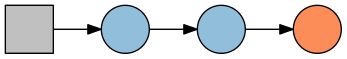

In [5]:
draw_graph("feed-forward")

The two blue circles represent hidden layers.  In the feed-forward architecture, they just feed activations further through the network.

In contrast, we represent a recurrent network like so:

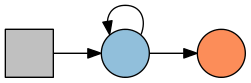

In [6]:
draw_graph("recurrent")

The hidden layers get input activations not just from the layer below, but from their (or other layer's) output at a previous step.  These hidden activations incorporate the previous state of the network, thereby providing some memory of the previous inputs.  During training, the recurrent network will learn how to weight both the current features and the previous state in making decisions.

An alternative approach would be to have inputs not just for the current time, but for *n* previous times.  As long as the connections are set up appropriately, this could give similar performance.  However, it would require inputs of a fixed length.  In contrast, RNNs can take inputs of arbitrary length, since all of the previous input, of whatever length, is represented in the hidden activations.

It was proven in 2006 by Schäfer and Zimmerman that RNNs with sigmoid activations are **Turing-complete**.  That is, any program can be written by giving a RNN the appropriate weights.  This is only a theoretical results; there is no method to find those weights for a particular task.  However, it's easier to use an optimization algorithm to explore the space of weight matrices than the space of Python programs, for example.

## Backpropagation through time

You might remember that we said at the very beginning of the very first notebook that TensorFlow graphs must be acyclic.  Yet we just drew a diagram of a RNN with a loop in it.  How can we put this into TensorFlow?

The trick is to **unroll** or unfold the RNN through time.  That is, the recurrent edge is pointed not back to the same node, but to another copy, representing the next step in time.  And in that copy, this edge points to yet another copy, giving us a structure like so:

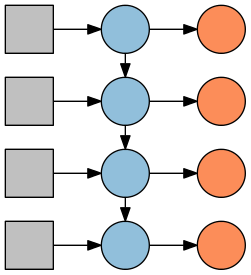

In [7]:
draw_graph("unrolled")

Although somewhat unusual, this is a perfectly good feed-forward network, and the standard backpropagation algorithm can be used with it.  The only wrinkle is that the weight matrices in all of the copies must stay in sync.  Therefore, we update them by summing all the gradients from all copies, similar to the way we handled convolutional filters.  This process in known as "backpropagation through time".

## Long-short term memory

If this is implemented naïvely, it will immediately run into problems with vanishing and exploding gradients.  To see why, recall that we can write the prediction of a feed-forward network as a set of nested functions.

$$ p = f_n\left( f_{n-1}\left( \cdots f_2\left( f_1\big( x W_1 \big) W_2 \right) \cdots W_{n-1} \right) W_n \right) $$

(We've dropped the bias terms for simplicity.)  To update $W_1$, for example, we need to calculate

$$ \frac{\partial p}{\partial W_1} = f_n' \big(\cdots\big) W_n \cdot f_{n-1}'\big(\cdots\big) W_{n-1} \cdot\cdots\cdot f_2'\big(\cdots\big) W_2 \cdot f_1'\big(x W_1) \cdot x$$

If each of these terms are greater than one, the whole gradient gradient will become large.  This will require a small learning-rate to avoid the optimizer diverging.  If each of the the terms are less than one, the gradient will vanish, and the weight won't change appreciably.

This is a general problem in deep networks, but with a generic network we can at least hope that we'll have terms both less than and greater than one, so that the whole gradient remains finite.  In an RNN, though, these nested functions represent previous copies of the network, so all of the weights are the same!  Unless they happen to be exactly one, we're guaranteed to get an explosion or a vanishing!

This issue has been dubbed the "fundamental problem of deep learning".  Several solutions have been proposed, but the current *de facto* standard is **long-short term memory**  (LSTM).  LSTM replaces the simple neurons with LSTM cells.  Each of those has an internal loop, allowing it to remember the state from previous runs.  That loop has a fixed weight of 1 and a linear activation.  This ensure that local derivative is always one, so backpropagation can proceed without the gradient vanishing or exploding.  This internal gate is proceeded and followed by two nonlinear (usually sigmoid) gates.  These gates are responsible for learning how to weight the internal state compared to the new inputs.

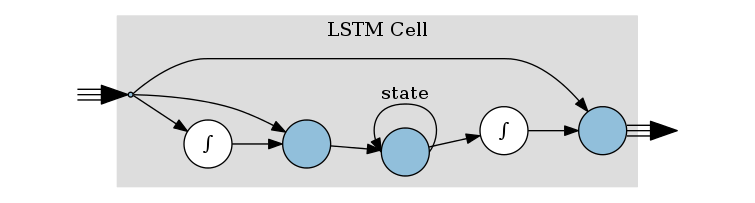

In [8]:
draw_graph("LSTM")

There are several sophistications commonly added to the basic LSTM cell.  One is a forget gate, added to the internal loop in the cell.  This bias should be initialized to one, so that the cell starts in a remembering state.  Should it be necessary, the cell can more easily learn to forget its state.

Another extension is peephole connections, which connect the internal state the the gates inside of the cell. There is some evidence that these improve the performance tasks requiring precise intervals.  Both of these features are built into the LSTM cell provided by TensorFlow.

## Applications

Layers of recurrent cells are typically not used alone.  At the very least, a full-connected feed-forward layer is used following the recurrent layer.  This translates the individual memories into the expected output.  More complicated architectures are common, with several recurrent and several feed-forward layers combined.  Convolutional layers may also be used when the problem calls for them, for example in processing video.

Recurrent networks can be used for a number of different applications.  The examples we've draw so far illustrate **sequence labeling**.  For each input, we calculate all the way through to the output.  This could be used, for example, to classify words in a sentence by their part of speech.  We need a label for each word, and the recurrent nature lets us use the past words to differentiate between, for example, the word "rows" in "Jack rows the boat" and "Jack walked between rows of wheat."

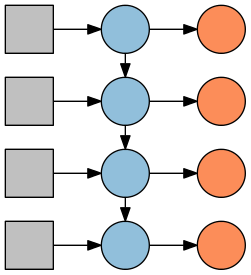

In [9]:
draw_graph("unrolled")

Sometimes, we care only about a single label for the whole sequence.  This is known as **sequence classification**.  We read the output associated only with the final input.  The recurrent nature ensures that this output has information from all of the inputs.  This could be used to classify the sentiment of a review text, for example.

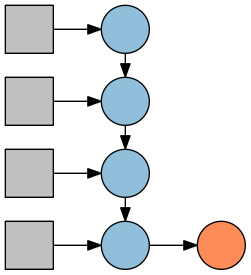

In [10]:
draw_graph("classification")

The situation is essentially reversed for **sequence generation**.  In this case, we take only a single input and wish to generate a whole sequence of output.  We can do this by feeding the output from one step (suitably processed, perhaps) as input to the next time step.  This can be used to generate text that resembles some corpus, as we demonstrate below. 

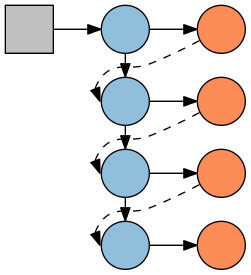

In [11]:
draw_graph("generation")

The ideas of classification and generation can be combined in **sequence translation**.  Here, an input sequence is fed into a network to establish a certain internal state.  This state is then used as the start of a decode sequence.  This can be done with two related RNNs or with a single one.  In the latter case a special token is needed to indicate to the network when to start outputting the translated version, as illustrated below.  Google used such networks for its [recent improvement](https://www.nytimes.com/2016/12/14/magazine/the-great-ai-awakening.html?_r=0) of its translation service.

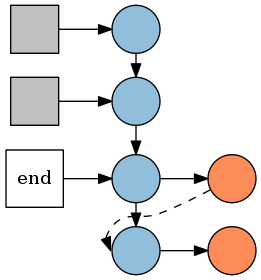

In [12]:
draw_graph("translation")

## Example: Generating strata abstracts

Here, we demonstrate a simple example of using sequence generation to create text.  We will train a neural network on a corpus of data consisting of abstracts of talks from past Strata conferences.  The networks will be trained to predict the next letter the appears in the abstract.  Once trained, the network can be used to generate an abstract by starting it off with a seed, and then continuing the sequence with letters chosen according the the probabilities output by the network.

We start by reading in the data we've already downloaded.  The abstracts are saved in a text file, one per line.

In [13]:
txt = open('small_data/strata_abstracts.txt', 'r').read().lower()

print len(txt)
print 
print txt[:1000]

1525206

samoa is an open-source platform for mining big data streams that runs on several distributed stream processing engines (such as s4 and storm), and includes streaming algorithms for the most common machine learning tasks such as classification and clustering. more info at http://samoa-project.net
how to extend your toolbox to solve more big data problems with less effort. aws provides a set of big data services that are elastic, scalable and highly available out of the box. learning best practices and tips of how to integrate them together and with your architecture adds to your abilities to provide fast and reliable big data solutions.
live demo of building an intelligent big data application from a web console. the tools and apis behind are built on top of spark, shark, tachyon, mesos, aurora, cassandra, ipython and include: elt pipeline (ingestion and transformation), data warehouse explorer, export to nosql and generated apis, predictive model building, training and publis

We'll want to one-hot encode the characters, so first we need to convert them to numbers.  We could just take their ASCII values, but this would give us a larger vocabulary than we need.  So instead we work out our own encoding, based on the characters we actually see.

In [14]:
chars = list(set(txt))
data = [chars.index(c) for c in txt]

We will be training with the minibatch method.  This function will generate a batch of data.  Each batch contains `batch_size` sequences, each `time_steps` in length.  (Note that, for simplicity, we are ignoring the fact that newlines should end the abstract.)  The labels to be predicted are the following letters.

In [15]:
def get_next_batch(batch_size, time_steps, data):
    x_batch = np.zeros((batch_size, time_steps))
    y_batch = np.zeros((batch_size, time_steps))
    
    batch_ids = range(len(data) - time_steps - 1)
    batch_id = random.sample(batch_ids, batch_size)
    
    for t in xrange(time_steps):
        x_batch[:, t] = [data[i+t] for i in batch_id]
        y_batch[:, t] = [data[i+t+1] for i in batch_id]
        
    return x_batch, y_batch

In [16]:
get_next_batch(1, 5, data)

(array([[ 52.,  54.,  49.,  37.,  39.]]),
 array([[ 54.,  49.,  37.,  39.,  53.]]))

We've chosen an architecture with 2 layers of 256 LSTM cells.  We will train on batches of 50 sequences of length 100.

In [17]:
n_layers = 2
n_chars = len(chars)
lstm_size = 256

time_steps = 100
batch_size = 50

We are using the `BasicLSTMCell`.  Despite the name, it actually implements an entire LSTM layer.  TensorFlow also provides a `LSTMCell` which includes peephole connections and some other features.

The `MultiRNNCell` combines several individual layers in sequence.  We will use two layers of the same size here.  Then we use use a fully-connected linear layer to combine the output of the RNN layers into output of the size we desire.

The `dynamic_rnn` function does a dynamic unrolling of the RNN to accomplish backpropagation through time.  It returns not only the output of the RNN, but a tensor giving the state, or hidden activations, of the RNN.

In [18]:
def make_lstm(x, lstm_init_value, n_chars, lstm_size, n_layers):
    # LSTM
    lstm = tf.contrib.rnn.MultiRNNCell(
        [tf.contrib.rnn.BasicLSTMCell(lstm_size, forget_bias=1.0, state_is_tuple=False)
         for _ in xrange(n_layers)],
        state_is_tuple=False)

    # Iteratively compute output of recurrent network
    out, lstm_new_state = tf.nn.dynamic_rnn(lstm, x, initial_state=lstm_init_value, dtype=tf.float32)

    # Linear activation (FC layer on top of the LSTM net)
    out_reshaped = tf.reshape(out, [-1, lstm_size])
    y = tf.layers.dense(out_reshaped, n_chars, activation=None)
    
    return y, tf.shape(out), lstm_new_state

The RNNs are flexible enough to take input of an arbitrary number of batches of arbitrarily long sequences.  Thus, the shapes are given as `(None, None)`.  We'll also need an input to initialize the RNN's state.

In [19]:
reset_tf()

x = tf.placeholder(tf.int32, shape=(None, None), name="x")
y_true = tf.placeholder(tf.int32, (None, None))
lstm_init_value = tf.placeholder(tf.float32, shape=(None, n_layers*2*lstm_size),
                                 name="lstm_init_value")

We need to one-hot encode both the input and the output.

In [20]:
x_enc = tf.one_hot(x, depth=n_chars)
y_true_enc = tf.one_hot(y_true, depth=n_chars)

These values get fed into our net.

In [21]:
y_pred, out_shape, lstm_new_state = make_lstm(x_enc, lstm_init_value, n_chars, lstm_size, n_layers)

The predictions come out flattened, so if we want an array in the same shape as the input, we need to reshape it.

In [22]:
final_out = tf.reshape(tf.nn.softmax(y_pred), 
                       (out_shape[0], out_shape[1], n_chars))

We'll use the cross-entropy as our loss function.  There are other metrics worth considering, including the [perplexity](https://en.wikipedia.org/wiki/Perplexity).

In [23]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=y_pred,
        labels=tf.reshape(y_true_enc, [-1, n_chars])))
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

The Root Mean Square Propagation (RMSProp) optimizer attempts to set a custom learning rate for each parameter.  It has been found to work well with RNNs.

In [24]:
optimizer = tf.train.RMSPropOptimizer(0.003, 0.9).minimize(loss)

In [25]:
#Merge all summaries
merged = tf.summary.merge_all()

To generate the text, we'll need to run the network one step at a time, while preserving the internal state.  This way, we can keep feeding back in the value that we produced in the previous step to move forward.

In [26]:
def run_step(seed, chars, init_value):
    test_data = [[chars.index(c) for c in seed]]
        
    out, next_lstm_state = sess.run([final_out, lstm_new_state], 
                                    {x:test_data, lstm_init_value:[init_value]} )
    return out[0][0], next_lstm_state[0]

For the actual generation, we first run the network on some seed text.  The last output gives us a set of probabilities for the next letter.  We choose that letter with those probabilities, append it to the string we are generating, and then advance the state of the network as if this were the next input.

In [27]:
def generate_text(seed, len_test_txt=500):
    seed = seed.lower()

    lstm_last_state = np.zeros((n_layers*2*lstm_size,))
    for c in seed:
        out, lstm_last_state = run_step(c, chars, lstm_last_state)
    
    gen_str = seed
    for i in range(len_test_txt):
        ele = np.random.choice(range(len(chars)), p=out)
        gen_str += chars[ele]
        out, lstm_last_state = run_step(chars[ele], chars, lstm_last_state)
    
    return gen_str

And now we're ready to go!  We'll run the optimizer for a while.  As we go, we'll print out sample text, so we can see what's being learned.

In [28]:
display_step = 50

reset_vars()

#Create summary writers
logs_path = datetime.now().strftime("%Y%m%d-%H%M%S") + '/summaries'
train_writer = tf.summary.FileWriter(logs_path + '/train', graph=tf.get_default_graph())

# Start-time used for printing time-usage below.
start_time = time.time()

step = 1
for i in range(num_iterations):

    # Get a batch of training examples.
    x_batch, y_true_batch = get_next_batch(batch_size, time_steps, data)

    # ---------------------- TRAIN -------------------------
    # optimize model
    init_value = np.zeros((x_batch.shape[0], n_layers*2*lstm_size))
    sess.run(optimizer, feed_dict={x: x_batch, y_true: y_true_batch, lstm_init_value:init_value}) 


    # Print status every 100 iterations.
    if (i % display_step == 0) or (i == num_iterations - 1):

        summary, l = sess.run([merged, loss], feed_dict={x: x_batch, y_true: y_true_batch, lstm_init_value:init_value})
        train_writer.add_summary(summary, step)

        # Message for network evaluation
        msg = "Optimization Iteration: {0:>6}, Training Loss: {1:>6}"
        print(msg.format(i, l))
        print "  " + generate_text("We", 60)

        step += 1

# Ending time.
end_time = time.time()

# Difference between start and end-times.
time_dif = end_time - start_time

# Print the time-usage.
print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

# Close summary writer
train_writer.close()

Optimization Iteration:      0, Training Loss: 4.15764045715
  we4?)
) !i~ b(0>5|=#r$7p':wc^6i<b:tzq(264<6;d<h>&3p;!4u~iszb-<
Optimization Iteration:     50, Training Loss: 3.99845075607
  we!$=`3~`@i8z3q=u3#jk6zv?|j"#,)(('y`'c4<g?j~dr|`'%xks=/
1adhw;
Optimization Iteration:    100, Training Loss: 3.06374502182
  wet>assgmr %anna iyn|aelcarltaa nosnlpreroi tcorneitas siprina
Optimization Iteration:    150, Training Loss: 3.02548122406
  weocns  bofdaktaeahac escmom dmeeeesm-k,nersams etm ttdl.,ptnl
Optimization Iteration:    200, Training Loss: 2.8960621357
  we7lat eapsole eng e tksirt  twi  nreart ounopmo  om ps,kde us
Optimization Iteration:    250, Training Loss: 2.35483026505
  wessr.ong cfonter paldencerreskudicettsrsta pon did wha tunly

Optimization Iteration:    300, Training Loss: 2.08897805214
  wer tresg fow the well of sealerute..
tto we prig the e 1r exm
Optimization Iteration:    350, Training Loss: 1.91081058979
  wecot buy fhakl sof and whit begle the thit ial apopttat

Now, let's generate some abstracts!

In [29]:
print generate_text("We", 500)

we are team an analytical everying and real-time data storities of the cleallers and analysis and presects into things are datiflersaintes data science, that capturations and a new was cwals-stuly problems and performam, and healthcare, and the oreanting-realing codca/jumized mosical. this talk optimalists, social datakayeshss. with the human ewar, two wide in real time is a som) alocadicalless seamless like and learningial code r partner.  sensiin and have simple need to real-time data, and the l


In [30]:
print generate_text("The", 500)

the sefferswiched in crigical data sql-ta criving. join lead when the breating quingining and current etcensing and explored data cangobales techmology, and biggering ways of appsed struggles and signific data for real-time and analytics, eloveration advan systems to apache mamoultionaltand more skinta data writh production about the new behavior bettouries exproced distributed distecy to adgicts to buile a hiad grets grefting data-driven busteres, and ased in more, their such as strata processing 


In [31]:
print generate_text("TensorFlow", 500)

tensorflows executive. rearsible and in-verience.
leveraging staction and flawly allow optlin, software developing networks, allowing scaled better schume as the finency and order to wire minin of the business, to loge combagen, detend exsed for with data, services.  and problem. hadoop platform to provide in the data scientists. aly roberce schema to consideraliusanteersist as trends. howea database. linkorizer capabilities and deployment for the performance, and visoa. de,ire interfaces, charlengmeranua


*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*